![](http://)**Detecting Pneumonia in X-Ray Images**

Using data from http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

![](https://i.imgur.com/jZqpV51.png)

Figure S6. Illustrative Examples of Chest X-Rays in Patients with Pneumonia, Related to Figure 6
The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.
http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5



*Step 1: Import Modules*

In [1]:
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
from scipy import ndimage
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization, SeparableConv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#from keras.applications.mobilenet import MobileNet
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve
#from sklearn.metrics import auc
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


*Step 2: Load Data*

Training is faster due to the image resizing here (?)

In [2]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/chest_xray/train/"
test_dir =  "../input/chest-xray-pneumonia/chest_xray/chest_xray/test/"
def get_data(folder):
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    # size to match pretrained vgg16 and inception networks
                    img_file = skimage.transform.resize(img_file, (150, 150, 3))
                    # size to match resnet50
                    #img_file = skimage.transform.resize(img_file, (200, 200, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
X_train, y_train = get_data(train_dir)
X_test, y_test= get_data(test_dir)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)

100%|██████████| 390/390 [00:13<00:00, 28.55it/s]


*Step 3: Vizualize Data*

The min/max pixel values are already scaled between 0 and 1 because its black and white.

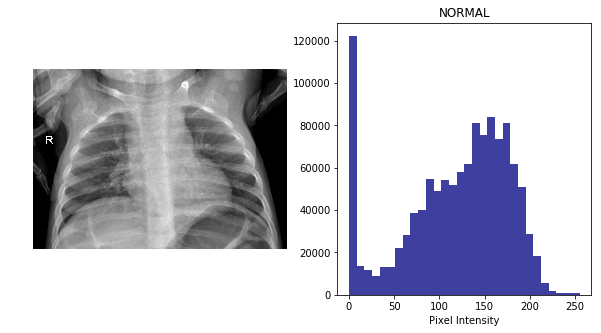

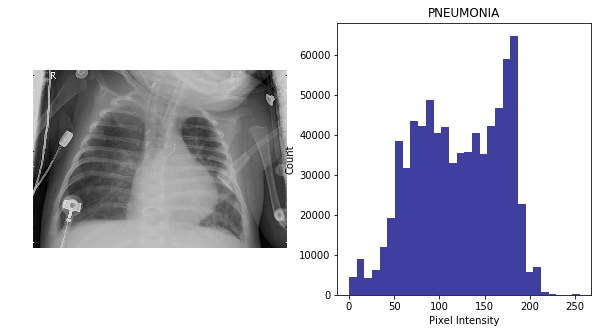

In [3]:
normal_images = glob('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/**')
pneumonia_images = glob('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/**')
def plotHistogram(a, label):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_title(label)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5)
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5)
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5)


plotHistogram(cv2.imread(normal_images[0]), "NORMAL")
plotHistogram(cv2.imread(pneumonia_images[0]), "PNEUMONIA")

3 X-Rays from category "No Pneumonia"

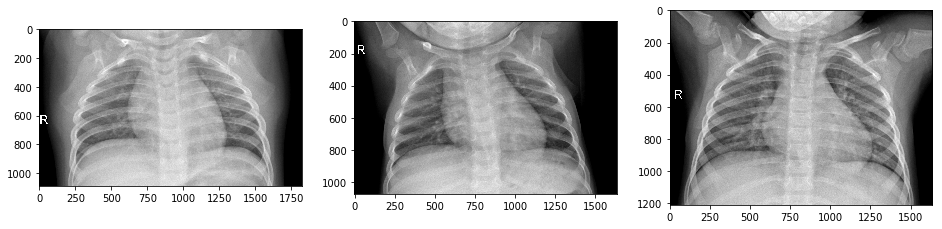

In [4]:
multipleImages = glob('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
plotThreeImages(multipleImages)

20 images from category "No Pneumonia"

No Pneumonia


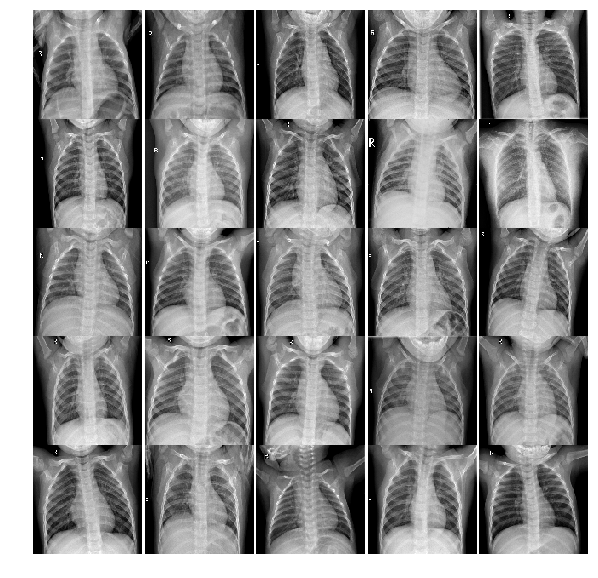

In [5]:
print("No Pneumonia")
multipleImages = glob('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

20 images from category "Yes Pneumonia"

Yes Pneumonia


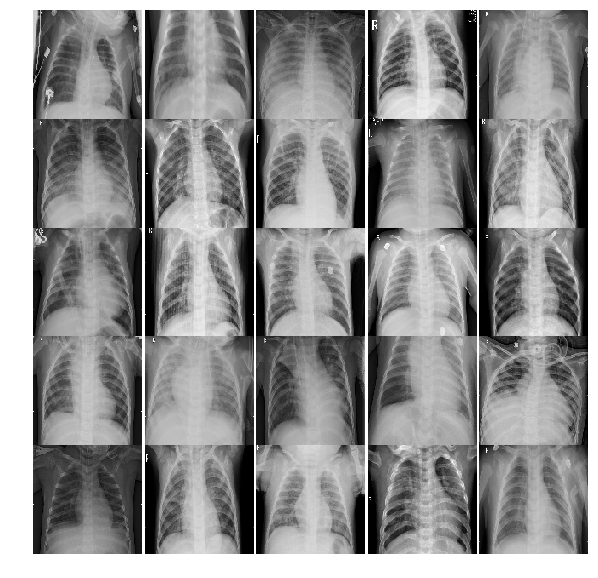

In [6]:
print("Yes Pneumonia")
multipleImages = glob('../input/chest-xray-pneumonia/chest_xray/chest_xray/train/PNEUMONIA/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

{0: 'No Pneumonia', 1: 'Yes Pneumonia'}


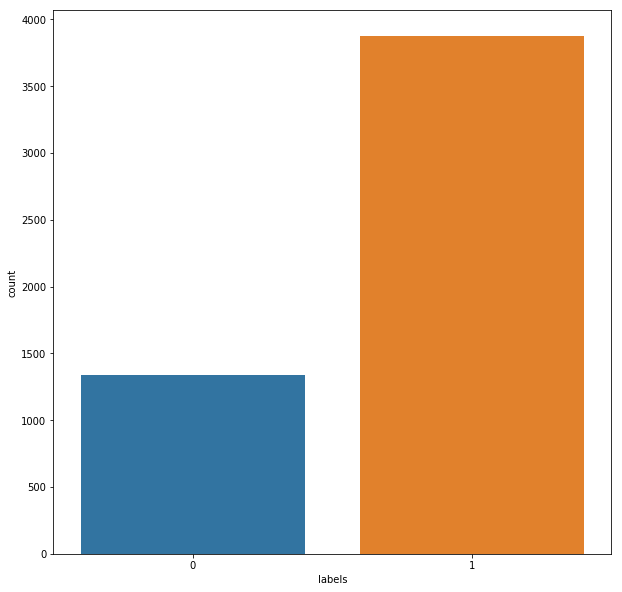

In [7]:
map_characters = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

*Step 4: Define Helper Functions*

In [8]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

*Step 5: Evaluate Classification Models*

Transfer learning w/ VGG16 Convolutional Network or Inception V3

Keras comes with a bunch of pre-trained models for various uses. You can check them out here: https://keras.io/applications/
This is a convinience function which allows us to easily try out different models.

VGG16:
https://www.cs.toronto.edu/~frossard/post/vgg16/
![VGG16](https://www.cs.toronto.edu/~frossard/post/vgg16/vgg16.png)

Inception v3:
https://cloud.google.com/tpu/docs/inception-v3-advanced
![Inception v3](https://codelabs.developers.google.com/codelabs/cpb102-txf-learning/img/4a077a942db85cb3.png)


In [9]:
map_characters1 = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
weight_path_vgg16 = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
weight_path_inception_v3 = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
weight_path_resnet50 = '../input/keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model_vgg16 = VGG16(weights = weight_path_vgg16, include_top=False, input_shape=(150, 150, 3))
pretrained_model_inception_v3 = InceptionV3(weights = weight_path_inception_v3, include_top=False, input_shape=(150, 150, 3))
pretrained_model_resnet50 = ResNet50(weights = weight_path_resnet50, include_top=False, input_shape=(200, 200, 3))
optimizer1 = keras.optimizers.RMSprop(lr=0.0001)

def pretrainedNetwork(xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,classweight,numclasses,numepochs,optimizer,labels):
    base_model = pretrainedmodel # Topless
    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    # Fit model
    history = model.fit(xtrain,ytrain, epochs=numepochs, class_weight=classweight, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()
    return model


Transfer learning w/ VGG16 Convolutional Network (must be done with (150,150,3) scaled input)

In [ ]:
pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_vgg16,weight_path_vgg16,class_weight1,2,3,optimizer1,map_characters1)

Transfer learning w/ VGG16 Convolutional Network (10 epochs)

In [ ]:
pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_vgg16,weight_path_vgg16,class_weight1,2,10,optimizer1,map_characters1)

Transfer learning w/ Resnet50 Convolutional Network
This was seen as a popular xray classifier in research.
This was abysmal on test data. 95% on training, but 50% on test. Possibly due to how the images are scaled. 

Look into this. https://stackoverflow.com/questions/47157526/resnet-100-accuracy-during-training-but-33-prediction-accuracy-with-the-same

![resnet50 classifier output](https://i.imgur.com/4GrvEVV.png)

In [ ]:
#pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_resnet50,weight_path_resnet50,class_weight1,2,20,optimizer1,map_characters1)

Transfer learning w/ InceptionV3 Convolutional Network

Currently this has great training accuracy, but lackluster performance on the test data. This is a likely candidate for overfitting. 

In [ ]:
pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,pretrained_model_inception_v3,weight_path_inception_v3,class_weight1,2,3,optimizer1,map_characters1)

*Step 6: Evaluate Undersampling Strategy*

The goal is to get rid of the class imbalance issues.  Oversampling with data augmentation (e.g. [SMOTE](http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html)) would be preferable to undersampling but undersampling is faster.

The imbalance is caused by the fact that the data has a lot more positive 'Yes Pneumonia' examples than negative. This means we can undersample to remove some of the positive examples and even out the data.
More info here: http://www.chioka.in/class-imbalance-problem/

{0: 'No Pneumonia', 1: 'Yes Pneumonia'}


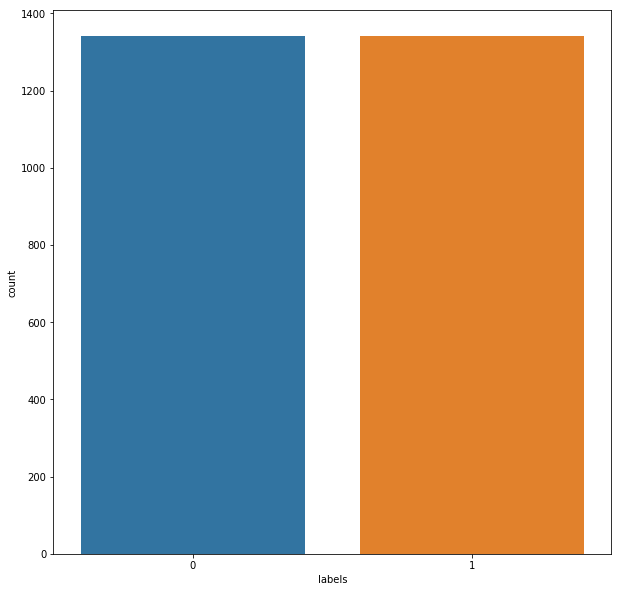

In [10]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
Y_test = y_test
#ros = RandomOverSampler(ratio='auto')
ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
# Make Data 2D again
for i in range(len(X_trainRos)):
    height, width, channels = 150,150,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
for i in range(len(X_testRos)):
    height, width, channels = 150,150,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
# Plot Label Distribution
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

In [14]:
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
print("Old Class Weights: ",class_weight1)
class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight2)

Old Class Weights:  [1.9448173  0.67303226]
New Class Weights:  [1. 1.]


*Step 7: Evaluate Final Model*

Transfer learning w/ VGG16 Convolutional Network

In [ ]:
pretrainedNetwork(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,pretrained_model_vgg16,weight_path_vgg16,class_weight2,2,6,optimizer1,map_characters1)

Transfer learning w/ InceptionV3 Convolutional Network

In [ ]:
pretrainedNetwork(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,pretrained_model_inception_v3,weight_path_inception_v3,class_weight2,2,6,optimizer1,map_characters1)

 We were able to detect pneumonia in x-ray images with an accuracy rate of approximately 85%.  Great!

Adding a new node to the last layer of the pre-trained model and observing the change in results.
The original pretrained network here is actually already doing that when it adds a top layer, so we will try something slightly different.
For more info on these see: https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975
or any other information on fine tuning pretrained Keras models.

(As suggested by Sageev)

Here is a comparison of ReLU and Softmax:
https://github.com/Kulbear/deep-learning-nano-foundation/wiki/ReLU-and-Softmax-Activation-Functions

Softmax is generally good for classifying inputs with multiple possible outputs (ex: classifying which of the 9 possible hand written digits we are seeing). The output of a softmax can be seen as a probability distribution across categories.

The sigmoid activation function is more commonly used to two-class problems such as this so we would expect it to perform better, see: https://stats.stackexchange.com/questions/233658/softmax-vs-sigmoid-function-in-logistic-classifier



In [11]:
def modifiedPretrainedNetwork(xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,classweight,numclasses,numepochs,optimizer,labels):
    base_model = pretrainedmodel # Topless
    
    # Add top layer classifier model to the CNN
    x = base_model.output
    x = Flatten()(x)
    top_layer_relu = Dense(numclasses, activation='relu')(x)
    # need dropout here?
    top_layer_sigmoid = Dense(2, activation='sigmoid')(top_layer_relu)
    model = Model(inputs=base_model.input, outputs=top_layer_sigmoid)
    
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    # Fit model
    history = model.fit(xtrain,ytrain, epochs=numepochs, class_weight=classweight, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()
    return model

Transfer learning w/ VGG16 Convolutional Network and classifier model

As expected the sigmoid activation function seems to be classifying better (expand on why).

Seems to top out around 10-12 epochs (why?).

Randomly can have really bad classification, look into this.

In [ ]:
modifiedPretrainedNetwork(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,pretrained_model_vgg16,weight_path_vgg16,class_weight2,2,3,optimizer1,map_characters1)

# Testing Pre-processing Sharpened Data

Load data as sharpened images to test results...

Using image sharpening from: https://www.scipy-lectures.org/advanced/image_processing/auto_examples/plot_sharpen.html

In [ ]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/chest_xray/train/"
test_dir =  "../input/chest-xray-pneumonia/chest_xray/chest_xray/test/"
def get_sharpened_data(folder):
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (150, 150, 3))
                    
                    blurred_img = ndimage.gaussian_filter(img_file, 3)
                    filter_blurred_img = ndimage.gaussian_filter(blurred_img, 1)
                    # tried out some different alpha values, this seems like a good one for not introducing artifacts
                    alpha = 15
                    sharpened = blurred_img + alpha * (blurred_img - filter_blurred_img)
    
                    img_arr = np.asarray(sharpened)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
sharpened_X_train, sharpened_y_train = get_sharpened_data(train_dir)
sharpened_X_test, sharpened_y_test= get_sharpened_data(test_dir)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
sharpened_y_trainHot = to_categorical(sharpened_y_train, num_classes = 2)
sharpened_y_testHot = to_categorical(sharpened_y_test, num_classes = 2)

Transfer learning w/ VGG16,  sharpened images

no undersampling (yet)

Looks like, it has a negative effect on classification, probably due to the artifacts that are introduced by sharpening.

In [ ]:
class_weight3 = class_weight.compute_class_weight('balanced', np.unique(sharpened_y_train), sharpened_y_train)
pretrainedNetwork(sharpened_X_train, sharpened_y_trainHot, sharpened_X_test, sharpened_y_testHot,pretrained_model_vgg16,weight_path_vgg16,class_weight3,2,10,optimizer1,map_characters1)

# Stripping and specializing layers
## Important: Currently just working on this with vgg16 in mind.

LeNet-style models, stacks of convolutions for feature extraction and max-pooling operations for spatial sub-sampling

TODO: Testing layer 5 batch normalization.

In [32]:
adam_optimizer = keras.optimizers.RMSprop(lr=0.0001, decay=1e-5)

# For training model after stripping layers
def strippedPretrainedNetwork(xtrain,ytrain,xtest,ytest,model,classweight,numepochs,optimizer,labels):
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    
    # Fit model
    history = model.fit(xtrain,ytrain, epochs=numepochs, class_weight=classweight, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()
    return model


def oneStrippedLayer(xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,classweight,numclasses,numepochs,optimizer,labels):
    base_model = pretrainedmodel # Topless
    
    # Train top layer only
    for layer in base_model.layers:
        layer.trainable = False
    # Remove the 5th block entirely
    base_model.layers.pop()
    base_model.layers.pop()
    base_model.layers.pop()
    base_model.layers.pop()
    out = base_model.layers[-1].output
    #base_model.summary()
    
    x = out
    # Layer 5
    conv5_1 = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='conv5_1')(x)
    bn5_1 = BatchNormalization(name='bn5_1')(conv5_1)
    conv5_2 = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='conv5_2')(bn5_1)
    bn5_2 = BatchNormalization(name='bn5_2')(conv5_2)
    conv5_3 = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='conv5_3')(bn5_2)
    pool5 = MaxPooling2D((2,2), name='pool5')(conv5_3)
    
    # Output layer
    flattened = Flatten(name='flatten')(pool5)
    top_layer_relu = Dense(numclasses, activation='relu', name='fully_con_1')(flattened)
    top_layer_dropout = Dropout(0.7, name='dropout')(top_layer_relu)
    top_layer_softmax = Dense(2, activation='softmax', name='fully_con_2')(top_layer_dropout)
    #top_layer_sigmoid = Dense(2, activation='sigmoid')(top_layer_dropout)

    model = Model(inputs=base_model.input, outputs=top_layer_softmax)
    return strippedPretrainedNetwork(xtrain,ytrain,xtest,ytest,model,classweight,numepochs,optimizer,labels)


def twoStrippedLayers(xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,classweight,numclasses,numepochs,optimizer,labels):
    base_model = pretrainedmodel # Topless
    
    # Train new layers only
    for layer in base_model.layers:
        layer.trainable = False
    # Remove the 5th block entirely
    base_model.layers.pop()
    base_model.layers.pop()
    base_model.layers.pop()
    base_model.layers.pop()
    # Remove the 4th block entirely
    base_model.layers.pop()
    base_model.layers.pop()
    base_model.layers.pop()
    base_model.layers.pop()
    out = base_model.layers[-1].output
    #base_model.summary()
    
    x = out
    # Layer 4
    conv4_1 = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='conv4_1')(x)
    bn4_1 = BatchNormalization(name='bn4_1')(conv4_1)
    conv4_2 = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='conv4_2')(bn4_1)
    bn4_2 = BatchNormalization(name='bn4_2')(conv4_2)
    conv4_3 = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='conv4_3')(bn4_2)
    pool4 = MaxPooling2D((2,2), name='pool4')(conv4_3)
    
    # Layer 5
    conv5_1 = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='conv5_1')(pool4)
    bn5_1 = BatchNormalization(name='bn5_1')(conv5_1)
    conv5_2 = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='conv5_2')(bn5_1)
    bn5_2 = BatchNormalization(name='bn5_2')(conv5_2)
    conv5_3 = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='conv5_3')(bn5_2)
    pool5 = MaxPooling2D((2,2), name='pool5')(conv5_3)
    
    # Output layer
    flattened = Flatten(name='flatten')(pool5)
    top_layer_relu = Dense(numclasses, activation='relu', name='fully_con_1')(flattened)
    top_layer_dropout = Dropout(0.7, name='dropout')(top_layer_relu)
    top_layer_softmax = Dense(2, activation='softmax', name='fully_con_2')(top_layer_dropout)
    #top_layer_sigmoid = Dense(2, activation='sigmoid')(top_layer_dropout)

    model = Model(inputs=base_model.input, outputs=top_layer_softmax)
    return strippedPretrainedNetwork(xtrain,ytrain,xtest,ytest,model,classweight,numepochs,optimizer,labels)

Transfer learn VGG16 w/ a trainable batch norm layer

Outputs of 100 epochs and RMS prop optimizer:
![100 epochs](https://i.imgur.com/IA0xkwb.png)

Outputs of 400 epochs and Adam optimizer in repo images folder.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

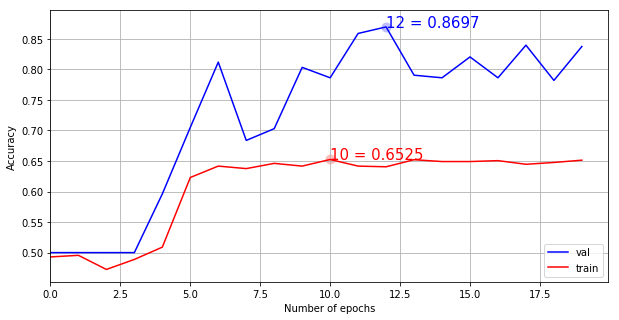

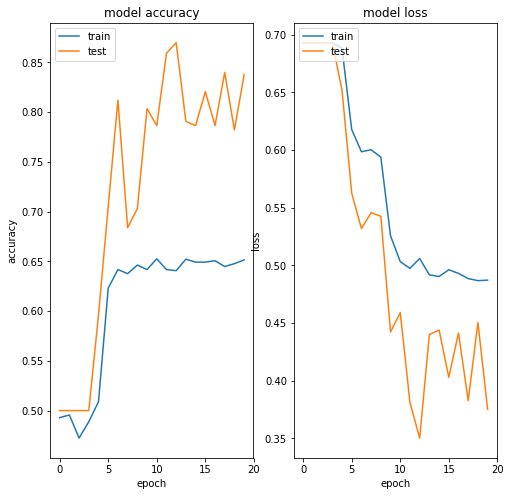

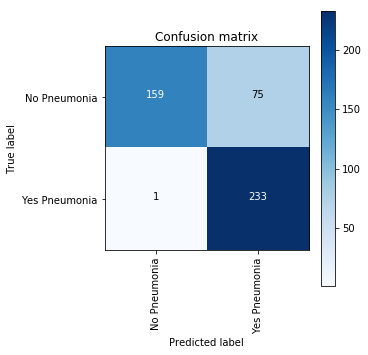

In [26]:
# Redeclare the model so that we know which layers we are popping
weight_path_vgg16 = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model_vgg16 = VGG16(weights = weight_path_vgg16, include_top=False, input_shape=(150, 150, 3))
oneStrippedLayer(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,pretrained_model_vgg16,weight_path_vgg16,class_weight2,2,20,optimizer1,map_characters1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Epoch 32/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5719 - acc: 0.6573 - val_loss: 0.8074 - val_acc: 0.7009
Epoch 33/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5675 - acc: 0.6626 - val_loss: 0.5326 - val_acc: 0.8355
Epoch 34/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5806 - acc: 0.6454 - val_loss: 0.4806 - val_acc: 0.8825
Epoch 35/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5801 - acc: 0.6465 - val_loss: 0.5563 - val_acc: 0.8098
Epoch 36/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5746 - acc: 0.6529 - val_loss: 1.4320 - val_acc: 0.5897
Epoch 37/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5780 - acc: 0.6484 - val_loss: 0.5551 - val_acc: 0.8440
Epoch 38/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5778 - acc: 0.6488 - val_loss: 1.1892 - val_acc: 0.6432
Epoch 39/200
2682/2682 [=================

Epoch 92/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5690 - acc: 0.6596 - val_loss: 1.1746 - val_acc: 0.7201
Epoch 93/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5888 - acc: 0.6353 - val_loss: 1.0510 - val_acc: 0.7543
Epoch 94/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5838 - acc: 0.6409 - val_loss: 0.8787 - val_acc: 0.8098
Epoch 95/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5824 - acc: 0.6424 - val_loss: 0.9661 - val_acc: 0.8077
Epoch 96/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5812 - acc: 0.6439 - val_loss: 0.9754 - val_acc: 0.8056
Epoch 97/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5776 - acc: 0.6480 - val_loss: 1.0836 - val_acc: 0.7735
Epoch 98/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5733 - acc: 0.6529 - val_loss: 0.8236 - val_acc: 0.7991
Epoch 99/200
2682/2682 [=================

2682/2682 [==============================] - 15s 6ms/step - loss: 0.5740 - acc: 0.6521 - val_loss: 1.6058 - val_acc: 0.7115
Epoch 152/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5683 - acc: 0.6585 - val_loss: 0.8770 - val_acc: 0.8312
Epoch 153/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5720 - acc: 0.6544 - val_loss: 1.0065 - val_acc: 0.8077
Epoch 154/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5727 - acc: 0.6536 - val_loss: 1.2540 - val_acc: 0.7692
Epoch 155/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5704 - acc: 0.6562 - val_loss: 1.3378 - val_acc: 0.7415
Epoch 156/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5753 - acc: 0.6506 - val_loss: 1.3775 - val_acc: 0.7350
Epoch 157/200
2682/2682 [==============================] - 15s 6ms/step - loss: 0.5786 - acc: 0.6477 - val_loss: 0.8795 - val_acc: 0.8077
Epoch 158/200
2682/2682 [=======================

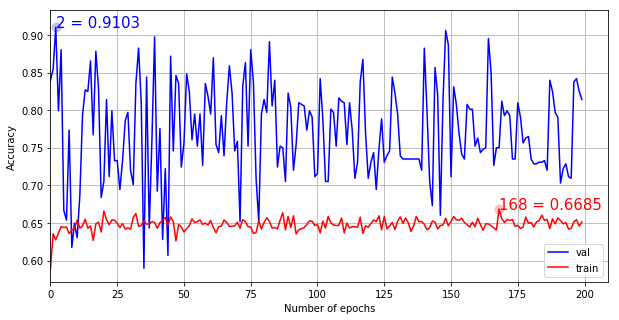

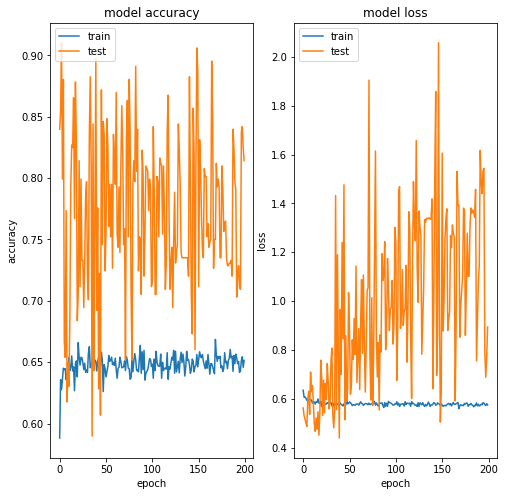

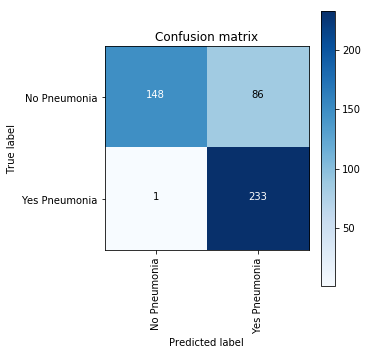

In [34]:
# Redeclare the model so that we know which layers we are popping
weight_path_vgg16 = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model_vgg16 = VGG16(weights = weight_path_vgg16, include_top=False, input_shape=(150, 150, 3))
twoStrippedLayers(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,pretrained_model_vgg16,weight_path_vgg16,class_weight2,2,20,optimizer1,map_characters1)

To Do: (1) Add data augmentation (sharpening maybe); (2) guided backprop; (3)pruning; (4) Try oversampling 

Early  stopping?